In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
import sys
parent_path = os.path.abspath("../../")
sys.path.append(parent_path)

In [3]:
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 80
mpl.rcParams["savefig.dpi"] = 80 

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchseis.attributes.local_orient_slope import structure_tensor_orientations2d, structure_tensor_orientations3d

In [5]:
def plot_direction_field(image, u1, u2, el=None,
                         step=20,
                         mode="normal",   # "normal", "tangent" or "all"
                         scale=5,
                         color="red"):
    """
    Parameters
    ----------
    image : ndarray (W,H)
    u1,u2,el : ndarray (W,H)
    step : int
    mode : str
        one of ['normal', 'tangent', 'all']
    scale : float
    color : str
    """
    dx, dy = 1.0, 1.0
    W, H = image.shape
    X, Y = np.mgrid[step:W:step, step:H:step]

    if mode == "normal":
        U = u1[step::step, step::step]
        V = u2[step::step, step::step]
    elif mode == "tangent":
        Nx = u1 * dx
        Ny = u2 * dy
        Tx = -Ny
        Ty =  Nx
        U = Tx[step::step, step::step]
        V = Ty[step::step, step::step]
    elif mode == 'all':
        U1 = u1[step::step, step::step]
        V1 = u2[step::step, step::step]
        Nx = u1 * dx
        Ny = u2 * dy
        Tx = -Ny
        Ty =  Nx
        U2 = Tx[step::step, step::step]
        V2 = Ty[step::step, step::step]
    else:
        raise ValueError("mode must be 'normal' or 'tangent'")

    plt.figure(figsize=(4,4))
    plt.imshow(image.T, cmap="gray", origin="upper", interpolation='bilinear')
    if el is not None:
        cmap = plt.get_cmap('jet')
        cmap.set_over('red', 0)
        plt.imshow(el.T, cmap='jet', alpha=0.15, origin="upper", interpolation='bilinear')
    if mode == 'all':
        plt.quiver(X, Y, U1, V1,
                   color='red',
                   angles="xy", scale_units="xy", headwidth=2, headlength=6,
                   scale=scale)
        plt.quiver(X, Y, U2, V2,
                   color='blue',
                   angles="xy", scale_units="xy", headwidth=2, headlength=6,
                   scale=scale)
    else:
        plt.quiver(X, Y, U, V,
                color=color,
                angles="xy", scale_units="xy",
                scale=scale, headwidth=2, headlength=4)
    plt.scatter([240, 240, 40, 40, 360], [80, 160, 200, 360, 360], c='white', marker='s', s=8)
    plt.axis('off')
    # plt.xlim(0, 400)
    plt.tight_layout()
    # plt.savefig('f3.pdf', bbox_inches='tight', pad_inches=0.01, dpi=300)
    plt.show()


## 2d

### Java result

The java implementation can be found at: [https://github.com/xinwucwp/mhe/blob/a458d9bd5185cde0e03fc95dd4df3f91174f4872/src/mhe/demo3.py#L39](https://github.com/xinwucwp/mhe/blob/a458d9bd5185cde0e03fc95dd4df3f91174f4872/src/mhe/demo3.py#L39)

In [6]:
root = '/home/lijintao/data/slope/2d/'

In [7]:
sx = np.load(root + 'f2d.npy')
u1 = np.load(root + 'u1.npy')
u2 = np.load(root + 'u2.npy')
el = np.load(root + 'el.npy')

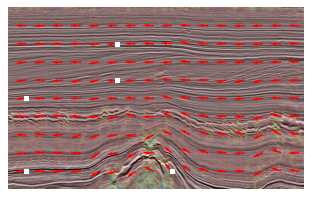

In [8]:
plot_direction_field(sx, u2, u1, el=el, step=40, mode="tangent", scale=0.04, color="red") # normal or tangent


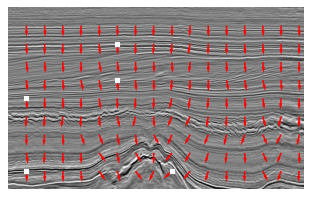

In [9]:
plot_direction_field(sx, u2, u1, step=40, mode="normal", scale=0.04, color="red") # normal or tangent


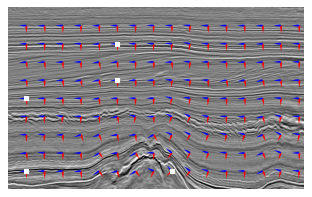

In [10]:
plot_direction_field(sx, u2, u1, step=40, mode="all", scale=0.06, color="red") # normal or tangent


In [11]:
print(el.min(), el.max())

0.11234084 0.9989498


### torch version - 2d, axis order=(X, T)

In [12]:
### input shape, inp.shape = (1, 1, X, T), taxis=-1, or taxis=3

inp = torch.from_numpy(sx).unsqueeze(0).unsqueeze(0)
out = structure_tensor_orientations2d(inp, -1, (2.0, 8.0), outputs=['u', 'lty'])

In [13]:
# Note that the axis order is (X, T), so out['u'] = [ux, ut]
ux, ut = out['u']
lty = out['lty']

# Don't transpose
ux = ux[0, 0].cpu().numpy()
ut = ut[0, 0].cpu().numpy()
lty = lty[0, 0].cpu().numpy()

In [14]:
print(ux.shape, sx.shape, lty.shape)

(651, 400) (651, 400) (651, 400)


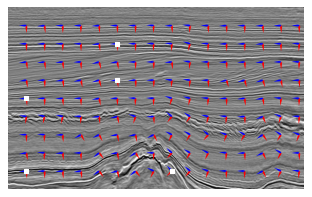

In [15]:
# plot_direction_field(sx, ux, ut, step=20, mode="tangent", scale=0.06, color="red") # normal or tangent
plot_direction_field(sx, ux, ut, step=40, mode="all", scale=0.06, color="red") # normal or tangent


In [16]:
print(el.min(), el.max(), lty.min(), lty.max())

0.11234084 0.9989498 0.10204836 0.9979851


### torch version - 2d, axis order=(T, X)

In [17]:
### input shape, inp.shape = (1, 1, T, X), taxis=-2, or taxis=2

inp = torch.from_numpy(sx.T).unsqueeze(0).unsqueeze(0)
out = structure_tensor_orientations2d(inp, -2, (8.0, 2.0), outputs=['u', 'lty'])

In [18]:
# Note that the axis order is (T, X), so out['u'] = [ut, ux]
ut, ux = out['u']
lty = out['lty']

# we need transpose to match sx
ux = ux[0, 0].cpu().numpy().T
ut = ut[0, 0].cpu().numpy().T
lty = lty[0, 0].cpu().numpy().T

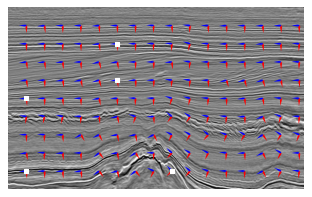

In [19]:
plot_direction_field(sx, ux, ut, step=40, mode="all", scale=0.06, color="red") # normal or tangent


In [20]:
print(el.min(), el.max(), lty.min(), lty.max())


0.11234084 0.9989498 0.10204615 0.9979851


## 3d

### java result 3d

In [21]:
root = '/home/lijintao/data/slope/3d/'

In [22]:
sx = np.load(root + 'f3.npy')
u1 = np.load(root + 'u1.npy')
u2 = np.load(root + 'u2.npy')
u3 = np.load(root + 'u3.npy')
el = np.load(root + 'el.npy')
ep = np.load(root + 'ep.npy')


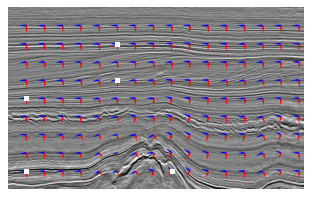

In [23]:
plot_direction_field(sx[500], u2[500], u1[500], step=40, mode="all", scale=0.06, color="red") # normal or tangent


### torch version 3d, axis order is (T, X, I)

In [24]:
### input shape, inp.shape = (1, 1, T, X, I), taxis=-3, or taxis=2


x = torch.from_numpy(sx.T).unsqueeze(0).unsqueeze(0).cuda()
out = structure_tensor_orientations3d(x, 2, (8.0, 2.0, 2.0), ['u', 'lty', 'pty'])

# Note that the axis order is (T, X, I), so out['u'] = [ut, ux, ui]
ut, ux, ui = out['u']

# Transpose
ut = ut.detach().squeeze().cpu().numpy().T
ux = ux.detach().squeeze().cpu().numpy().T
ui = ui.detach().squeeze().cpu().numpy().T
lty = out['lty'].detach().squeeze().cpu().numpy().T
pty = out['pty'].detach().squeeze().cpu().numpy().T

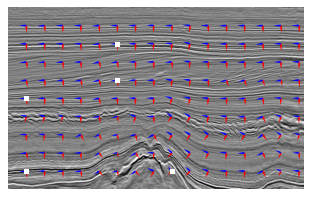

In [25]:
plot_direction_field(sx[500], ux[500], ut[500], step=40, mode="all", scale=0.06, color="red") # normal or tangent


In [26]:
print(el.min(), el.max(), ep.min(), ep.max())
print(lty.min(), lty.max(), pty.min(), pty.max())

0.0 0.9994679 0.0 1.0
0.0 1.0 0.0 1.0


### torch version 3d, axis order is (I, X, T)

In [27]:
### input shape, inp.shape = (1, 1, I, X, T), taxis=-1, or taxis=4


x = torch.from_numpy(sx).unsqueeze(0).unsqueeze(0).cuda()
out = structure_tensor_orientations3d(x, -1, (2.0, 2.0, 8.0), ['u', 'lty', 'pty'])

# Note that the axis order is (I, X, T), so out['u'] = [ui, ux, ut]
ui, ux, ut = out['u']

# No need transpose
ut = ut.detach().squeeze().cpu().numpy()
ux = ux.detach().squeeze().cpu().numpy()
ui = ui.detach().squeeze().cpu().numpy()
lty = out['lty'].detach().squeeze().cpu().numpy()
pty = out['pty'].detach().squeeze().cpu().numpy()

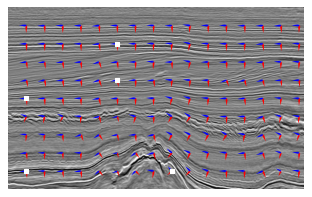

In [28]:
plot_direction_field(sx[500], ux[500], ut[500], step=40, mode="all", scale=0.06, color="red") # normal or tangent

In [29]:
print(el.min(), el.max(), ep.min(), ep.max())
print(lty.min(), lty.max(), pty.min(), pty.max())

0.0 0.9994679 0.0 1.0
0.0 1.0 0.0 1.0
